# Лабораторная работа 1. Морфологический анализ

### Задание 1.
1. Изучить демонстрационный ноутбук `"Сегментация и токенизация"`.
1. Выберите наилучшую, на ваш взгляд, библиотеку для сегментации и токенизации.

### Задание 2.
1. Изучите документацию и лицензию морфологического парсера [pymorphy2](https://pymorphy2.readthedocs.io).
1. Установите `pymorphy2`.

### Задание 3.
Напишите функцию `parse_text()`, на вход которых поступает текст (в виде строки), а на выходе формируется список, содержащий для каждого слова входного текста следующую информацию:
- исходную словоформу (`wordform`);
- нормальную форму слова (лемму) (`norm` или `lemma`);
- часть речи (part of speech, `pos`);
- другую грамматическую информацию, выдаваемую `pymorphy2`;
- признак, присутствует ли слово в словаре `pymorphy2`.

Функция должна выбирать наиболее вероятный вариант морфологического разбора слова.


In [1]:
text0 = 'Напишите функцию parse_text(), на вход которых поступает текст (в виде строки), а на выходе формируется список, содержащий для каждого слова входного текста следующую информацию:'

In [2]:
text1 = 'Крепостного права я не знал и не видел, но помню, у тетки Анны Герасимовны чувствовал его. Въедешь во двор и сразу ощущаешь, что тут оно еще вполне живо. Усадьба – небольшая, но вся старая, прочная, окруженная столетними березами и лозинами. Надворных построек – невысоких, но домовитых – множество, и все они точно слиты из темных дубовых бревен под соломенными крышами. Выделяется величиной или, лучше сказать, длиной только почерневшая людская, из которой выглядывают последние могикане дворянского сословия – какие-то ветхие старики и старухи, дряхлый повар в отставке, похожий на Дон-Кихота. Все они, когда въезжаешь во двор, подтягиваются и низко-низко кланяются. Седой кучер, направляющийся от каретного сарая взять лошадь, еще у сарая снимает шапку и по всему двору идет с обнаженной головой. Он у тетки ездил форейтором, а теперь возит ее к обедне, - зимой в возке, а летом в крепкой, окованной железом тележке, вроде тех, на которых ездят попы. Сад у тетки славился своей запущенностью, соловьями, горлинками и яблоками, а дом – крышей. Стоял он во главе двора, у самого сада, - ветки лип обнимали его, - был невелик и приземист, но казалось, что ему и веку не будет, - так основательно глядел он из-под своей необыкновенно высокой и толстой соломенной крыши, почерневшей и затвердевшей от времени. Мне его передний фасад представлялся всегда живым: точно старое лицо глядит из-под огромной шапки впадинами глаз, - окнами с перламутровыми от дождя и солнца стеклами.'

In [3]:
text2 = 'дождище душещипательская истоия дождь кстати еще дождик машина машинка машинное душещипательская земля земельный идет дождь школа и сервис отца с дождём и огнём воды сразу с обрыва в облака облачные шторм шёл назад и вперёд'

In [4]:
import stanza
import pymorphy2
import sys
import re
import os
import copy
import json
import time
from matplotlib import pyplot as plt
import numpy as np

In [5]:
stanza.download("ru")

2021-10-21 17:30:31 INFO: Downloading default packages for language: ru (Russian)...
2021-10-21 17:30:34 INFO: File exists: C:\Users\EnergyYo\stanza_resources\ru\default.zip.
2021-10-21 17:30:41 INFO: Finished downloading models and saved to C:\Users\EnergyYo\stanza_resources.


In [6]:
text_example = copy.copy(text2)

In [7]:
gr = {
    "NOUN":"имя существительное",
    "ADJF": "имя прилагательное (полное)",
    "NOUN":"имя существительное",
    "ADJF":"имя прилагательное (полное)",
    "ADJS":"имя прилагательное (краткое)",
    "COMP":"компаратив",
    "VERB":"глагол (личная форма)",
    "INFN":"глагол (инфинитив)",
    "PRTF":"причастие (полное)",
    "PRTS":"причастие (краткое)",
    "GRND":"деепричастие",
    "NUMR":"числительное",
    "ADVB":"наречие",
    "NPRO":"местоимение-существительное",
    "PRED":"предикатив",
    "PREP":"предлог",
    "CONJ":"союз",
    "PRCL":"частица",
    "INTJ":"междометие",
    "nomn":"именительный",
    "gent":"родительный",
    "datv":"дательный",
    "accs":"винительный",
    "ablt":"творительный",
    "loct":"предложный",
    "voct":"звательный",
    "gen2":"второй родительный (частичный)",
    "acc2":"второй винительный",
    "loc2":"второй предложный (местный)",
    "masc":"мужской род",
    "femn":"женский род",
    "neut":"средний род",
    "LATN":"Токен состоит из латинских букв (например, “foo-bar” или “Maßstab”)",
    "PNCT":"Пунктуация (например, , или !? или …)",
    "NUMB":"Число (например, “204” или “3.14”)",
    "intg":"целое число (например, “204”)",
    "real":"вещественное число (например, “3.14”)",
    "ROMN":"Римское число (например, XI)",
    "UNKN":"Токен не удалось разобрать",
}

In [8]:
ORIGIN_WORD = 'OriginForm'
NORMAL_FORM = 'NormalForm'
POS = 'POS'
CASE = 'Case'
GENDER = 'Gender'
DICT_EXIST = 'FromDict'
WORDS = "Words"
FREQ = "Freq"
UNIQ = "uniquies"
COUNT = "count"
PRECISION = 5

In [9]:
def print_dict(d):
    print(json.dumps(d, indent=4, ensure_ascii=False))

In [10]:
morph = pymorphy2.MorphAnalyzer()
nlp = stanza.Pipeline(lang='ru', processors='tokenize')

2021-10-21 17:30:45 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |

C:\Users\EnergyYo\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2021-10-21 17:30:45 INFO: Use device: cpu
2021-10-21 17:30:45 INFO: Loading: tokenize
2021-10-21 17:30:45 INFO: Done loading processors!


In [52]:
def get_data(t):
    return 'None' if t is None else t

def get_is_known(t):
    return True if t else False

def parse_text(text):
    ret = []
    t = nlp(text)
    tokens = []
    for sentence in t.sentences:
        tokens += [token.text for token in sentence.tokens]
    for word in tokens:
        if re.match(r'\w+', word):
            parsed = morph.parse(word)[0]
            data = {
                ORIGIN_WORD : word,
                NORMAL_FORM : parsed.normal_form,
                POS         : get_data(gr.get(parsed.tag.POS)),
                CASE        : get_data(gr.get(parsed.tag.case)) ,
                GENDER      : get_data(gr.get(parsed.tag.gender)),
                DICT_EXIST  : get_is_known(morph.word_is_known(word)),
            }
            ret.append(data)              
    return ret

In [89]:
re.match(r'\w+', 'Как-нибудь')

<re.Match object; span=(0, 3), match='Как'>

In [90]:
parse_text('Как-нибудь, АН-52, 45')

[{'OriginForm': 'Как-нибудь',
  'NormalForm': 'как-нибудь',
  'POS': 'наречие',
  'Case': 'None',
  'Gender': 'None',
  'FromDict': True},
 {'OriginForm': 'АН',
  'NormalForm': 'ан',
  'POS': 'союз',
  'Case': 'None',
  'Gender': 'None',
  'FromDict': True},
 {'OriginForm': '52',
  'NormalForm': '52',
  'POS': 'None',
  'Case': 'None',
  'Gender': 'None',
  'FromDict': False},
 {'OriginForm': '45',
  'NormalForm': '45',
  'POS': 'None',
  'Case': 'None',
  'Gender': 'None',
  'FromDict': False}]

### Задание 4.
Напишите функцию `save_morph_results()`, сохраняющую структуру данных, получаемую функцией `parse_text()`, в текстовый файл формата JSON.

In [54]:
def save_morph_results(d, filename='morph_results'):
    with open(f"{filename}.json", "w+", encoding='utf-8') as f:
        tojs = json.dumps(d, indent=4, ensure_ascii=False)
        f.write(tojs)

In [55]:
save_morph_results(parse_text(text_example))

### Задание 5.
Напишите функцию `get_dictionary()`, на вход которой поступает структура данных, получаемая функцией `parse_text()`, а на выходе формируется словарь, ключами которого являются все нормальные формы слов текста, а в качестве значений хранится следующая информация:
- часть речи слова;
- частота слова в тексте;
- все варианты словоформ в тексте с данной нормальной формой.

In [158]:
def get_dictionary(parsed):
    tmp = {}
    
    for value in parsed:
        if tmp.get(value[NORMAL_FORM]) is None:
            tmp.update({
            value[NORMAL_FORM] : { 
                POS   : value[POS], 
                WORDS : set(([value[ORIGIN_WORD]])),
                FREQ : 1,
        }})
        else:
            tmp[value[NORMAL_FORM]][WORDS].add(value[ORIGIN_WORD])
            tmp[value[NORMAL_FORM]][FREQ] += 1
            
    return tmp

In [159]:
get_dictionary(parse_text(text_example))

{'дождище': {'POS': 'имя существительное', 'Words': {'дождище'}, 'Freq': 1}, 'душещипательский': {'POS': 'имя прилагательное (полное)', 'Words': {'душещипательская'}, 'Freq': 2}, 'истоия': {'POS': 'имя существительное', 'Words': {'истоия'}, 'Freq': 1}, 'дождь': {'POS': 'имя существительное', 'Words': {'дождь', 'дождём'}, 'Freq': 3}, 'кстати': {'POS': 'союз', 'Words': {'кстати'}, 'Freq': 1}, 'ещё': {'POS': 'наречие', 'Words': {'еще'}, 'Freq': 1}, 'дождик': {'POS': 'имя существительное', 'Words': {'дождик'}, 'Freq': 1}, 'машина': {'POS': 'имя существительное', 'Words': {'машина'}, 'Freq': 1}, 'машинка': {'POS': 'имя существительное', 'Words': {'машинка'}, 'Freq': 1}, 'машинный': {'POS': 'имя прилагательное (полное)', 'Words': {'машинное'}, 'Freq': 1}, 'земля': {'POS': 'имя существительное', 'Words': {'земля'}, 'Freq': 1}, 'земельный': {'POS': 'имя прилагательное (полное)', 'Words': {'земельный'}, 'Freq': 1}, 'идти': {'POS': 'глагол (личная форма)', 'Words': {'идет', 'шёл'}, 'Freq': 2}, '

### Задание 6.
Напишите функцию `save_dictionary()`, сохраняющую предыдущую структуру данных в текстовый файл формата JSON. Слова в файле должны быть упорядочены по убыванию частоты.

In [160]:
class SetEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        return super().default(self, obj)

In [163]:
def save_dictionary(d, filename='get_dictionary_results'):
    sorted_dict = sorted(d.items(), key=(lambda x: x[1][FREQ]), reverse=True)
    with open(f"{filename}.json", "w+", encoding='utf-8') as f:
        tojs = json.dumps(dict(sorted_dict), indent=4, ensure_ascii=False, cls=SetEncoder)
        f.write(tojs)

def save_dictionary2(d, filename='get_dictionary2_results'):
    with open(f"{filename}.json", "w+", encoding='utf-8') as f:
        tojs = json.dumps(d, indent=4, ensure_ascii=False)
        f.write(tojs)

In [164]:
save_dictionary(get_dictionary(parse_text(text_example)))

### Задание 7.
Напишите функцию `get_non_dict()`, на вход которой поступает структура данных, получаемая функцией `parse_text()`, а на выходе формируется словарь, содержащий слова текста, отсутствующие в словаре `pymorphy2`, вместе с частотой слова в тексте.

In [67]:
def get_non_dict(parsed):
    d = {}
    for v in parsed:
        if not v[DICT_EXIST]:
            count = d.get(v[ORIGIN_WORD], 0) + 1
            d.update({ v[ORIGIN_WORD] : count})
    return d

In [68]:
get_non_dict(parse_text(text_example))

{'душещипательская': 2, 'истоия': 1}

### Задание 8.
Напишите функцию `save_non_dict()`, сохраняющую структуру данных, получаемую функцией `get_non_dict()`, в текстовый файл формата TSV (tab-separated values). Слова в файле должны быть упорядочены по убыванию частоты.

In [84]:
def save_non_dict(data, filename="non_dict_results"):
    sorted_dict = dict(sorted(data.items(), key=(lambda x : x[1]), reverse=True))
    with open(f'{filename}.tsv', 'w', encoding='utf-8') as tsvfile:
        for k, v in sorted_dict.items():
            tsvfile.write(f"{k}\t{v}\n")

In [85]:
save_non_dict(get_non_dict(parse_text(text_example)))

### Задание 9.
Напишите функцию `get_pos_distribution()`, на вход которой поступает словарь, формируемый функцией `get_dictionary()`, а на выходе выдается структура данных, содержащая частотное распределение частей речи в словаре:
- часть речи – количество уникальных слов – общее количество слов.

In [86]:
def get_pos_distribution(data):
    d = {}
    for v in data.values():
        if d.get(v[POS]) is None:
            d.update({v[POS] : {UNIQ : 1, COUNT : len(v[WORDS])}})
        else:
            d[v[POS]][UNIQ] += 1
            d[v[POS]][COUNT] += len(v[WORDS])
    return d

In [87]:
get_pos_distribution(get_dictionary(parse_text(text_example)))

{'имя существительное': {'uniquies': 15, 'count': 17},
 'имя прилагательное (полное)': {'uniquies': 4, 'count': 5},
 'союз': {'uniquies': 2, 'count': 4},
 'наречие': {'uniquies': 4, 'count': 4},
 'глагол (личная форма)': {'uniquies': 1, 'count': 2},
 'предлог': {'uniquies': 2, 'count': 3}}

In [88]:
save_dictionary2(get_pos_distribution(get_dictionary(parse_text(text_example))), "get_pos_distribution")

### Задание 10.
Создайте текстовую коллекцию - скачайте не менее **10 текстов** разных жанров и разного размера (например, произведения классиков, современных писателей, новостные статьи, научные статьи и т.п.).

Учитывайте кодировку – все файлы должны быть в UTF-8.

In [27]:
RESULTS_DIR = "results"
TEXTS_DIR = "texts"
SUCCESS = False
ERROR = True
FILE_NAME = "FIleName"
FILE_SIZE = "FileSizeBytes"
TOTAL_WORDS = "TotalWords"
TOTAL_UNIQUE_WORDS = "TotalUniqWords"
FILE_PROCESSING_TIME = "ProcessingTime"
FILE_PROCESSING_REPORT = "processing_report"

In [28]:
def get_names():
    try:
        path = os.path.join(os.getcwd(), TEXTS_DIR)
        print("[INFO]: path to texts: %s" % path)
        files = list(filter(lambda x : x.endswith('.txt'),  os.listdir(path)))
    except OSError as err:
        print(f"[ERROR]: unable to get files, {err}")
        sys.exit(1)
    else:
        return files

In [29]:
tmp = get_names()
tmp

[INFO]: path to texts: C:\Users\EnergyYo\Мой диск\NeuralNetworks-university-course\NN-2\lab1\texts


['rasskaz1.txt',
 'sci_1.txt',
 'sci_2.txt',
 'sci_3.txt',
 'sci_4.txt',
 'udiviteltaya_istokia.txt']

### Задание 11.
Обработайте текстовую коллекцию при помощи функций `parse_text()`, `get_dictionary()` и `get_non_dict()`, и сохраните результаты в текстовых файлах при помощи функций `save_morph_results()`, `save_dictionary()` и `save_non_dict()`.

Для каждого входного текстового файла выведите на экран следующую информацию:
- имя файла;
- размер файла в байтах;
- размер текста в словах (общее количество слов в тексте);
- размер словаря (количество уникальных слов в тексте);
- время обработки файла (в секундах).

In [30]:
def create_dir(name):
    try:
        path = os.path.join(os.getcwd(), name)
        os.mkdir(path)
    except FileExistsError:
        print(f"[WARNING]: directory '{name}' already exist")
    except OSError as err:
        print(f"[ERROR]: unable create a directory: {path};\n{err}")
        sys.exit(1)
    return path
    

def files_check(files):
    if len(files) == 0:
        print("[ERROR]: list of files is empty")
        sys.exit(1)
    else: 
        create_dir(RESULTS_DIR)

def get_uniq(pos_dist):
        counter = 0
        for k, v in pos_dist.items():
            counter += v[UNIQ]
        return counter

def analyze():
    report = {}

    files = get_names()
    files_check(files)
    try:
        # main logic
        for file in files:
        
            # prepare
            start_tic = time.perf_counter()
            
            file_name_only = os.path.splitext(file)[0]
            path = create_dir(os.path.join(RESULTS_DIR, file_name_only))
            with open(os.path.join(os.getcwd(), TEXTS_DIR, file), 'r', encoding='utf-8') as f:
                text = f.read()

            # analyze
            morph_results = parse_text(text)
            save_morph_results(morph_results, os.path.join(path, f'morph_results_{file_name_only}'))
            
            dictionary = get_dictionary(morph_results)
            save_dictionary(dictionary, os.path.join(path, f'dictionary_{file_name_only}'))
            
            save_non_dict(get_non_dict(morph_results), os.path.join(path, f'non_dict_{file_name_only}'))
            
            pos_distribution = get_pos_distribution(dictionary)
            save_dictionary2(pos_distribution, os.path.join(path, f'pos_distribution_{file_name_only}'))
            
            end_tic = time.perf_counter()

            # report for single file
            file # name of file
            file_size = os.path.getsize(os.path.join(os.getcwd(), TEXTS_DIR, file)) # size of txtfile in bytes
            total_words = len(morph_results) # total words of text
            total_uniqu_words = get_uniq(pos_distribution)
            processing_sec = round(end_tic - start_tic, 4) # processing time of single file

            report_elemet = {
                file : {
                    FILE_NAME : file,
                    FILE_SIZE : file_size,
                    TOTAL_WORDS : total_words,
                    TOTAL_UNIQUE_WORDS : total_uniqu_words,
                    FILE_PROCESSING_TIME : processing_sec,
            }}
            report.update(report_elemet)
        
        # save the report
        #print_dict(report)
        save_dictionary2(report, os.path.join(os.getcwd(), RESULTS_DIR, FILE_PROCESSING_REPORT))

    # exceptions
    except OSError as e:
        print(f"[ERROR]: OSError: {e}")
        return ERROR
    except TypeError as e:
        print(f"[ERROR]: TypeEror: {e}")
        return ERROR
    except Exception as e:
        print(f"[ERROR]: unhandeled: {e}")
        return ERROR
    return SUCCESS

In [31]:
err = analyze()
if err:
    print("[ERROR]: analysis error")
else:
    print("[SUCCESS]: the analysis is completed")

[INFO]: path to texts: C:\Users\EnergyYo\Мой диск\NeuralNetworks-university-course\NN-2\lab1\texts
[WARNING]: directory 'results' already exist
[WARNING]: directory 'results\rasskaz1' already exist
[WARNING]: directory 'results\sci_1' already exist
[WARNING]: directory 'results\sci_2' already exist
[WARNING]: directory 'results\sci_3' already exist
[WARNING]: directory 'results\sci_4' already exist
[WARNING]: directory 'results\udiviteltaya_istokia' already exist
[SUCCESS]: the analysis is completed


### Задание 12.
Для самого большого словаря выполните следующее:
- постройте частотное распределение слов: по оси ординат – частота, по оси абсцисс – слова, упорядоченные по убыванию частоты (по-другому, *ранги* слов). В качестве значений на оси абсцисс можно выводить ранги слов, а не сами слова;
- постройте в виде диаграммы распределение частей речи, полученное функцией `get_pos_distribution()`.

In [32]:
def get_path_to_results():
    # read a report of analysis
    with open(os.path.join(os.getcwd(), RESULTS_DIR, FILE_PROCESSING_REPORT + ".json")) as f:
        report_data = json.load(f)
    # find a file with a maximun TotalWords
    total_max = 0
    for k, v in report_data.items():
        if v[TOTAL_WORDS] > total_max:
            total_max = v[TOTAL_WORDS]
            max_total_words_filename = v[FILE_NAME]
    # getting dict data for this file
    path = os.path.join(os.getcwd(), RESULTS_DIR, os.path.splitext(max_total_words_filename)[0]) # path to dir with analysis results for this file
    return path, max_total_words_filename

In [175]:
def task1():
    path, filename = get_path_to_results()
    with open(os.path.join(path, f"dictionary_{os.path.splitext(filename)[0]}.json"), "r", encoding='utf-8') as f:
        dict_data = json.load(f)
    # form new dict for plot: { word : freq, ... }
    dict_plot = {}
    for k, v in dict_data.items():
        dict_plot.update({k : v[FREQ]})
    # create plot
    #sorted_dict = dict(sorted(dict_plot.items(), key=(lambda x: x[1])))
    plt.figure(figsize=(30,5))
    #plt.plot(sorted_dict.values(), sorted_dict.keys())
    plt.plot(list(dict_plot.keys())[:100], list(dict_plot.values())[:100])
    plt.xticks(rotation=90)
    #plt.grid()
        

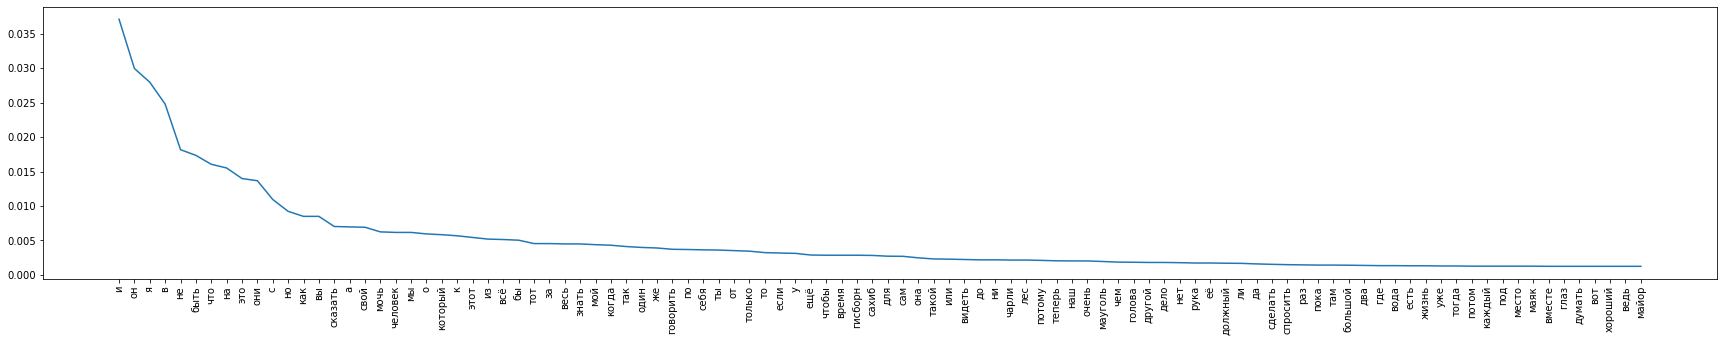

In [176]:
task1()

In [35]:
def task2():
    path, filename = get_path_to_results()
    with open(os.path.join(path, f"pos_distribution_{os.path.splitext(filename)[0]}.json"), "r", encoding='utf-8') as f:
        dict_data = json.load(f)
    # form new dict for plot: { pos : count_words, ... }
    dict_plot = {}
    for k, v in dict_data.items():
        dict_plot.update({k : v[COUNT]})
    # create plot
    dict_plot = dict(sorted(dict_plot.items(), key=(lambda x: x[1]), reverse=True))
    plt.plot(dict_plot.keys(), dict_plot.values())
    plt.grid()
    plt.xticks(rotation=90)
    

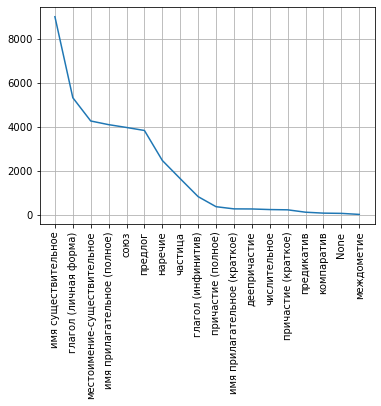

In [36]:
task2()

### Задание 13.
Постройте график зависимость времени морфологического анализа от размера текстового файла.

In [37]:
def task13():
    # read a report of analysis
    with open(os.path.join(os.getcwd(), RESULTS_DIR, FILE_PROCESSING_REPORT + ".json")) as f:
        report_data = json.load(f)
    # processing time by sile size analys
    data = [(v[FILE_SIZE], v[FILE_PROCESSING_TIME]) for _, v in report_data.items()]
    plt.plot([x[0] for x in data], [x[1] for x in data])
    plt.xlabel("file size (bytes)")
    plt.ylabel("processing time (sec)")

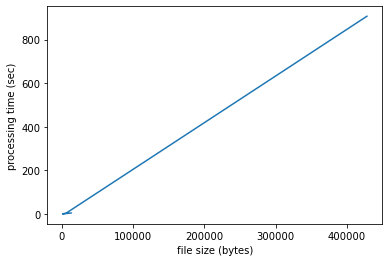

In [38]:
task13()